# datascience.bioinfo.guru

In [1]:
%autosave 0

Autosave disabled


# Supervised learning

Classification for proteins based on sequence information is an important tool for their functional annotation. Supervised machine learning algorithms are a lucrative option to develop classification models. Starting with a set to protein sequences that belong to a particular class (positive dataset) and a set of protein sequences that do not belong to that particualar class (negative dataset), machines learning model is built to classify unknown protein sequences. The model trains itself based on certain set of "features" that represent the different sequences in the two datasets. 

## Datasets

The first step for any supervised machine learning execise is to prepare a dataset having positive and negative cases. In our case we'll need a set of protein sequences that would represent positive and negative classes. We know that proteins are polymers made of 20 different amino acids. Proteins have been classified into different families based on their sequence similarity. For practice, we'll use some of the dataset that available in the literature. Below are two such datasets correponding to two different binary classification model building. 
- Positive and negative datasets corresponding to one of the protein families are available [here](https://webs.iiitd.edu.in/raghava/icaars/supplementary.html).
- A dataset comprising of UniProt IDs of postive and negative sequences is available [here](https://static-content.springer.com/esm/art%3A10.1038%2Fs41598-018-27338-9/MediaObjects/41598_2018_27338_MOESM1_ESM.xlsx). 

## Feature extraction

The next and one of the most important step in machine learning is feature extraction. For classifcation of protein sequences we cannot input the amino acid sequence directly to the classifier. So, we need to transform our data such that each sequence can be represent as a feature of constant length. Amino acid composition is one of the feature that can be used in this senario. Amino Acid Composition refers to frequency of each amino acid within a protein sequence. E.g. if a protein has a sequence 'MSAARQTTRKAE' it's amino acid composition can be represented as a vector of length 20:

'A':3,'C':0,'D':0,'E':1,'F':0,'G':0,'H':0,'I':0,'K':1,'L':0,'M':1,'N':0,'P':0,'Q':1,'R':1,'S':1,'T':2,'V':0,'W':0,'Y':0

In this way any protein sequence can be represented as a feature vector of fixed length. This is important because the protein sequences, even within the same class, can have different number of amino acids. To start with feature extraction and model building, we'll import the required libraries.

In [2]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from sklearn import model_selection
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

First, we'll use `SeqIO.parse` function to read the sequence files and make a dictionary of all the sequences using the `to_dict` function. This dictionary would have fasta header as the keys of the dictionary and the sequence object as the corresponding values. Then, using the `get_amino_acids_percent` function from the Biopython library, the amino acid composition for all the sequences will be calculated. The code below shows the output for this function using a dummy sequence.

In [3]:
p1 = ProteinAnalysis("AAAASTRRRTRRAWEQWERQW")
p1.get_amino_acids_percent()

{'A': 0.23809523809523808,
 'C': 0.0,
 'D': 0.0,
 'E': 0.09523809523809523,
 'F': 0.0,
 'G': 0.0,
 'H': 0.0,
 'I': 0.0,
 'K': 0.0,
 'L': 0.0,
 'M': 0.0,
 'N': 0.0,
 'P': 0.0,
 'Q': 0.09523809523809523,
 'R': 0.2857142857142857,
 'S': 0.047619047619047616,
 'T': 0.09523809523809523,
 'V': 0.0,
 'W': 0.14285714285714285,
 'Y': 0.0}

The code below creates the two dataframes one each for the positive and negative datasets. We'll add labels (as indicies) `1` and `-1` to indicate positive and negative classes, respectively.

In [9]:
positive_dict = SeqIO.to_dict(SeqIO.parse("positive-aars.fasta", "fasta"))
negative_dict = SeqIO.to_dict(SeqIO.parse("negative-aars.fasta", "fasta"))

## Amino acid composition calculation##
#c1 = ProteinAnalysis("AAAASTRRRTRRAWEQWERQW").count_amino_acids()
df1 = pd.DataFrame()
for keys,values in positive_dict.items():
    df1 = pd.concat([df1, pd.Series(ProteinAnalysis(str(values.seq)).get_amino_acids_percent(),name='1').to_frame().T])
for keys,values in negative_dict.items():
    df1 = pd.concat([df1, pd.Series(ProteinAnalysis(str(values.seq)).get_amino_acids_percent(),name='-1').to_frame().T])

print("Number of positive samples: ", len(positive_dict))
print("Number of negative samples: ", len(negative_dict))

df1

Number of positive samples:  117
Number of negative samples:  117


,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
1,0.035928,0.007984,0.041916,0.131737,0.055888,0.049900,0.017964,0.081836,0.119760,0.107784,0.015968,0.037924,0.037924,0.011976,0.037924,0.055888,0.049900,0.057884,0.013972,0.029940
1,0.076233,0.004484,0.049327,0.065770,0.029895,0.082212,0.020927,0.055306,0.082212,0.074738,0.040359,0.037369,0.043348,0.056801,0.058296,0.055306,0.061286,0.053812,0.017937,0.034380
1,0.093333,0.009524,0.068571,0.080000,0.026667,0.120000,0.024762,0.059048,0.055238,0.095238,0.028571,0.015238,0.041905,0.019048,0.074286,0.060952,0.020952,0.053333,0.009524,0.043810
1,0.079470,0.036424,0.052980,0.067881,0.046358,0.072848,0.023179,0.046358,0.021523,0.117550,0.019868,0.016556,0.046358,0.039735,0.081126,0.072848,0.049669,0.072848,0.008278,0.028146
1,0.084158,0.003300,0.046205,0.094059,0.034653,0.077558,0.018152,0.061056,0.089109,0.099010,0.036304,0.057756,0.031353,0.029703,0.026403,0.047855,0.042904,0.061056,0.011551,0.047855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-1,0.087221,0.004057,0.050710,0.060852,0.034483,0.068966,0.020284,0.056795,0.070994,0.089249,0.020284,0.036511,0.050710,0.042596,0.054767,0.079108,0.052738,0.075051,0.004057,0.040568
-1,0.067901,0.009259,0.049383,0.030864,0.027778,0.055556,0.024691,0.037037,0.030864,0.080247,0.015432,0.040123,0.111111,0.080247,0.104938,0.101852,0.058642,0.030864,0.018519,0.024691
-1,0.053521,0.010329,0.056338,0.101408,0.037559,0.037559,0.014085,0.059155,0.082629,0.110798,0.025352,0.059155,0.029108,0.047887,0.061033,0.078873,0.048826,0.046948,0.005634,0.033803
-1,0.038462,0.022869,0.070686,0.062370,0.062370,0.024948,0.014553,0.066528,0.060291,0.121622,0.016632,0.069647,0.027027,0.040541,0.050936,0.096674,0.061331,0.058212,0.009356,0.024948


Next, we'll check how these different amino acid compositions are correlated in our dataset. The pairwise correlations will be calculated using the `coor` function from the pandas library and the ploting is done using the `heatmap` function of the seaborn library. 

<AxesSubplot:>

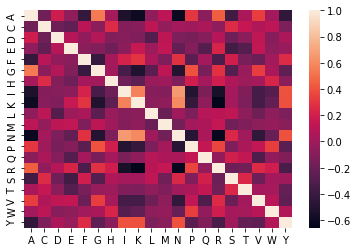

In [13]:
#correlation between different features 
sns.heatmap(df1.corr())

## Model building

Now, we'll split our data into training and testing sub-sets. The training set will be used to build the SVM model and the testing set will be used to test the accuracy of the model. The `train_test_split` function in `model_selection` is used to create these sub-set given the data matrix (X) and labels (Y). For this function, the `test_size` keyword argument determines the size for the training and testing sub-set. E.g., when `test_size` is set to 0.2 then this imply that the model training will be done using 80% of the data and testing will be performed using the remaining 20% of the data. This approach ensures that when we are test our model, we are using data that has _not_ been used for training the model. Subsequently, we'll build the SVM model using the training dataset and check its prediction accuracy using the testing dataset.

In [10]:
df1.index

Index(['1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       ...
       '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1', '-1'],
      dtype='object', length=234)

In [13]:
# Split-out validation dataset"
validation_size = 0.20 # 20% data for testing
seed = None # change to int for reproducibility
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(df1, df1.index, \
                                                                               test_size=validation_size, \
                                                                                random_state=seed)

new_clf = SVC()
model1 = new_clf.fit(X_train, Y_train)
Y_predicted = model1.predict(X_validation)
score1 = accuracy_score(Y_predicted, Y_validation)
print(score1)

0.723404255319149


## Cross-validation
One of the limitation of the approach used above is that we are not using the entire data for model building since a sub-set of data is set aside for testing. To overcome this limitation, the cross-validation approach is used. Here, multiple splits of the data are created and each of these splits are iteratively used for model building and testing. This way we have practically used the entire data for model building. This method is called kfold cross validation, where k indicates the number of splits.

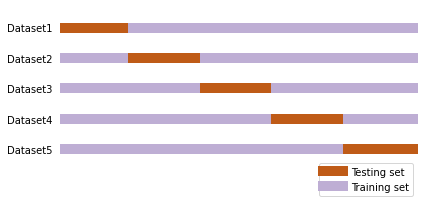

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Define a function to visualize cross-validation behavior
def plot_cv_indices(cv, X, y, n_splits, ax, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X, y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] =  1
        indices[tr] =  0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii +  0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=plt.cm.Accent,
            vmin=-0.2,
            vmax=1.2,
        )

    # Formatting
    yticklabels = list(range(n_splits)) + [""]
    ax.set(
        yticks=np.arange(n_splits +  1) +  0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits +  1.2, -0.2],
        xlim=[0, len(X)],
    )
    return ax

# Example usage
from sklearn.datasets import make_blobs

# Generate a synthetic dataset
X, y = make_blobs(n_samples=1000, n_features=2, centers=2, cluster_std=10.0, random_state=12345)

# Set up the cross-validation object
cv = KFold(n_splits=5)

# Create the plot
fig, ax = plt.subplots(figsize=(6,  3))
plot_cv_indices(cv, X, y, n_splits=5, ax=ax)

ax.spines[["top","bottom","left","right"]].set_visible(False)
ax.xaxis.set_ticks([])
ax.yaxis.set_ticklabels(["Dataset1","Dataset2","Dataset3","Dataset4","Dataset5",""])
ax.tick_params(axis='y', left=False)

plt.xlabel("")
plt.ylabel("")

# Legend
ax.legend(
    [plt.Line2D([0], [0], color=(0.7490196078431373, 0.3568627450980392, 0.09019607843137253, 1.0), lw=10, linestyle="solid"),
     plt.Line2D([0], [0], color=(0.7450980392156863, 0.6823529411764706, 0.8313725490196079, 1.0), lw=10, linestyle="solid")],
    ["Testing set", "Training set"],
    loc="lower right",
)
plt.tight_layout()
plt.show()


The `cross_val_score` function in `model.selection` class is used to perform the kfold cross validation by specifying the required value to the `cv` keyword argument. 

In [14]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

# Test options and evaluation metric
scoring = 'accuracy'

kfold = model_selection.KFold(n_splits=10)
cv_results = model_selection.cross_val_score(SVC(), df1, df1.index, cv=kfold, scoring=scoring)

print(cv_results)
print(cv_results.mean(), cv_results.std())

[0.54166667 0.625      0.5        0.83333333 0.60869565 0.69565217
 0.43478261 0.56521739 0.73913043 0.60869565]
0.6152173913043478 0.11104998581213907


In [15]:
SVC().get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

## Hyperparameters

In [16]:
clf_poly = SVC(kernel='poly', degree=3)
clf_rbf = SVC(kernel='rbf', C=10)

kfold = model_selection.KFold(n_splits=5)
cv_SVM_poly_results = model_selection.cross_val_score(clf_poly, df1, df1.index, cv=kfold, scoring=scoring)
cv_SVM_rbf_results = model_selection.cross_val_score(clf_rbf, df1, df1.index, cv=kfold, scoring=scoring)
print(cv_SVM_rbf_results)
print (cv_SVM_poly_results.mean(), cv_SVM_rbf_results.mean())

[0.70212766 0.65957447 0.78723404 0.5106383  0.65217391]
0.6281221091581869 0.6623496762257168


## Grid Search

In [17]:
from sklearn.model_selection import GridSearchCV
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000, 10000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000, 10000]},
                    {'kernel':['poly'], 'C': [1, 10, 100, 1000, 10000],
                     'degree': range(10)}]
clf_grid = GridSearchCV(SVC(), tuned_parameters, cv=5, scoring='accuracy')
clf_grid.fit(df1,df1.index)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000, 10000],
                          'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000, 10000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000, 10000],
                          'degree': range(0, 10), 'kernel': ['poly']}],
             scoring='accuracy')

In [18]:
print(clf_grid.best_params_)
#print(clf_grid.cv_results_)

{'C': 1, 'degree': 3, 'kernel': 'poly'}


Build a SVM model using above hyperparameters and check the prediction accuracy.

In [19]:
clf_poly = SVC(kernel='poly',C=1, degree=3)

kfold = model_selection.KFold(n_splits=5)
cv_SVM_results = model_selection.cross_val_score(clf_poly, df1, df1.index, cv=kfold, scoring=scoring)
print(cv_SVM_results)
print (cv_SVM_results.mean(),cv_SVM_results.std())

[0.70212766 0.65957447 0.76595745 0.40425532 0.60869565]
0.6281221091581869 0.12325451681757636


## Confusion matrix

In [21]:
from collections import Counter
from sklearn.metrics import confusion_matrix

In [22]:
clf_new = SVC(kernel='poly',degree=3, probability=True)

## Fit model to the data ##
clf_new.fit(df1,df1.index)
print(Counter(df1.index))

## Predict labels for the original data ##
clf_new_predict = clf_new.predict(df1)
print(Counter(clf_new_predict))

Counter({'1': 117, '-1': 117})
Counter({'-1': 121, '1': 113})


In [119]:
y_proba = clf_new.predict_proba(df1)
y_proba[0]

array([0.27016497, 0.72983503])

In [120]:
type(clf_new_predict)

numpy.ndarray

[[108   9]
 [ 13 104]]


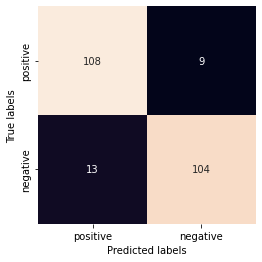

In [33]:
cm = confusion_matrix(labels,clf_new_predict)
print(cm)

fig,ax= plt.subplots()
sns.heatmap(cm, square=True, annot=True, fmt='g', cbar=False, ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.xaxis.set_ticklabels(['positive', 'negative'])
ax.yaxis.set_ticklabels(['positive', 'negative'])
plt.show()

In [23]:
import base64
from IPython.display import Image, display
import matplotlib.pyplot as plt
def mm(graph):
    graphbytes = graph.encode("utf8")
    base64_bytes = base64.b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url="https://mermaid.ink/img/" + base64_string))

mm("""
%%{init: {"quadrantChart": {"chartWidth": 300, "chartHeight": 300} }}%%
quadrantChart
    x-axis positive --> negative
    y-axis negative --> positive
    quadrant-1 False Negative
    quadrant-2 True Positive
    quadrant-3 False Positive
    quadrant-4 True Negative
""")


## ROC Curve

In [121]:
clf_new_predict = clf_new_predict.astype(int)
clf_new_predict

array([ 1,  1,  1, -1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,
       -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1,  1,  1, -1, -1, -1, -1, -1, -1,  1,  1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1

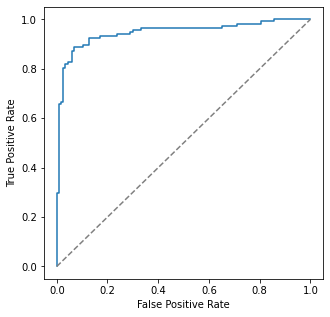

In [124]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

fpr, tpr, _ = roc_curve(df1.index.astype('int'), y_proba[:, 1])#clf_new_predict.astype('int'))
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
roc_display.figure_.set_size_inches(5,5)
plt.plot([0, 1], [0, 1], color = 'grey', linestyle="dashed")
plt.show()

### Exercise 

**Extract another feature - Di-Peptide Composition (DPC)**

For each sequence calculate the frequency of pairwaise occurrence of amino acids. The length of the feature vector for each sequence would be 400 (20 x 20). Construct a classification model using DPC as a feature and compare the results with classification using amino acid composition.


"ACDFERDFERALK" 20x20

In [7]:
import itertools
aa_list = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']

In [8]:
## Create a series of dipeptides
dpc_series = pd.Series(name='1',dtype=float)
for x in itertools.product(aa_list,aa_list):
    dpc_series[''.join([''.join(x)])] = 0
dpc_series

AA    0
AC    0
AD    0
AE    0
AF    0
     ..
YS    0
YT    0
YV    0
YW    0
YY    0
Name: 1, Length: 400, dtype: int64

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
df_dpc = pd.DataFrame([])
for keys,values in positive_dict.items():
    dpc_series_copy = dpc_series.copy()
#    print (values.seq)
    dpc_seq = [str(values.seq[i:i+2]) for i in range(len(values.seq))]
    del dpc_seq[-1]
    for x in dpc_seq:
        dpc_series_copy[x] += 1
    dpc_series_copy /= len(values.seq)
    dpc_series_copy *= 100
    df_dpc = df_dpc.append(dpc_series_copy)
#dpc_series_copy

In [11]:
df_dpc

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YM,YN,YP,YQ,YR,YS,YT,YV,YW,YY
1,0.399202,0.000000,0.000000,0.399202,0.399202,0.399202,0.199601,0.199601,0.598802,0.199601,...,0.199601,0.000000,0.598802,0.199601,0.000000,0.199601,0.000000,0.000000,0.0,0.000000
1,1.345291,0.000000,0.149477,0.747384,0.149477,0.597907,0.149477,0.298954,0.896861,0.448430,...,0.000000,0.000000,0.298954,0.448430,0.000000,0.000000,0.298954,0.597907,0.0,0.000000
1,0.571429,0.000000,0.761905,0.761905,0.380952,1.142857,0.190476,0.380952,0.571429,1.142857,...,0.000000,0.000000,0.000000,0.000000,0.761905,0.190476,0.190476,0.190476,0.0,0.000000
1,0.331126,0.165563,0.331126,0.496689,0.662252,0.662252,0.331126,0.000000,0.165563,0.496689,...,0.000000,0.165563,0.165563,0.331126,0.827815,0.331126,0.000000,0.165563,0.0,0.000000
1,0.495050,0.000000,0.660066,0.990099,0.165017,0.660066,0.000000,0.165017,0.825083,0.825083,...,0.165017,0.495050,0.165017,0.165017,0.165017,0.165017,0.165017,0.330033,0.0,0.330033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,0.790514,0.000000,0.592885,0.395257,0.592885,0.592885,0.197628,0.197628,1.185771,0.395257,...,0.000000,0.000000,0.197628,0.000000,0.395257,0.197628,0.000000,0.000000,0.0,0.000000
1,0.401606,0.000000,0.401606,0.200803,1.004016,0.200803,0.401606,0.000000,0.803213,0.200803,...,0.000000,0.000000,0.000000,0.401606,0.200803,0.602410,0.200803,0.803213,0.0,0.401606
1,2.923977,0.000000,1.754386,1.949318,1.169591,0.779727,0.194932,0.389864,0.000000,1.559454,...,0.000000,0.000000,0.194932,0.000000,0.584795,0.000000,0.000000,0.000000,0.0,0.000000
1,0.000000,0.000000,0.114416,0.114416,0.114416,0.114416,0.114416,0.114416,0.343249,0.114416,...,0.000000,0.228833,0.228833,0.000000,0.228833,0.228833,0.228833,0.228833,0.0,0.228833
